In [ ]:
from pyspark.sql import SparkSession
# from pyspark.sql.functions import col, udf
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
import numpy as npwwwwss
from pyspark.sql import functions as F
import re



In [ ]:
#spark session


# Create a Spark session with optimal configurations for your system
spark = SparkSession.builder \
    .appName("DomainDataAnalysis") \
    .config("spark.sql.shuffle.partitions", "4")\
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.cores", "2") \
    .config("spark.local.dir", "/tmp/spark-temp") \
    .config("spark.sql.warehouse.dir", "/tmp/spark-warehouse") \
    .config("spark.executor.memoryOverhead", "4g") \
    .config("spark.dynamicAllocation.enabled", "false") \
    .config("spark.cores.max", "8") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()




24/12/20 13:59:54 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [ ]:
# Load data
# broadcast_common_words = sc.broadcast(common_words)
top_500domains_csv = spark.read.csv("top500Domains.csv", header=True, inferSchema=True)

top_500domains_txt_raw = spark.read.text("top500Domains.txt")

# Function to split the line using regex to handle both tabs and spaces
def split_line(line):
    # Regex to split based on one or more spaces or tabs
    return re.split(r'\s{1,}', line)

# Apply the split_line function to each line
normalized_data = top_500domains_txt_raw.rdd.map(lambda row: split_line(row[0]))

# Map the data to a tuple format (Rank, Domain, SalePrice, SaleDate)
# Ensure proper handling if some fields are missing (e.g., SalePrice or SaleDate)
top_500domains_txt = normalized_data.map(lambda p: (
    int(p[0]),  # Rank
    p[1],       # Domain
    p[2] if len(p) > 2 else None,  # SalePrice
    p[3] if len(p) > 3 else None   # SaleDate
)).toDF(["Rank", "Domain", "SalePrice", "SaleDate"])
# sales_prices_category = spark.read.csv("Sales_Prices_Category.csv", header=True, inferSchema=True)
domain_data = spark.read.csv("DomainData.csv", header=True, inferSchema=True)
common_words = spark.read.text("EnglishMostCommonwords.txt").toDF("Word")
# sc = SparkContext.getOrCreate()  # Get the current SparkContext




In [ ]:
domain_data = domain_data.join(top_500domains_txt, on="Domain", how="left")
domain_data.show(5)
common_words_list = common_words.select("Word").rdd.flatMap(lambda x: x).collect()
broadcast_common_words = spark.sparkContext.broadcast(common_words_list)


+--------------------+--------+----+---------+--------+
|              Domain|category|Rank|SalePrice|SaleDate|
+--------------------+--------+----+---------+--------+
|          dkcorp.com|       1|NULL|     NULL|    NULL|
|   torontodining.com|       1|NULL|     NULL|    NULL|
|   valueregistry.com|       1|NULL|     NULL|    NULL|
|canadaconnection.com|       1|NULL|     NULL|    NULL|
|    dentaltrader.com|       1|NULL|     NULL|    NULL|
+--------------------+--------+----+---------+--------+
only showing top 5 rows



In [ ]:
# print the read data set
print("Top 500 domain csv")
top_500domains_csv.show()
print("Top 500 domain txt")
top_500domains_txt.show()
print("Domain Data")
domain_data.show()
print("common words")
common_words.show()

Top 500 domain csv
+----+--------------------+--------------------+----------------+
|Rank|         Root Domain|Linking Root Domains|Domain Authority|
+----+--------------------+--------------------+----------------+
|   1|         youtube.com|          22,173,670|             100|
|   2|      www.google.com|          14,072,847|             100|
|   3|           apple.com|           6,368,757|             100|
|   4|     www.blogger.com|          29,389,261|              99|
|   5|  support.google.com|           5,253,500|              99|
|   6|        linkedin.com|          11,605,442|              99|
|   7|       microsoft.com|           5,116,419|              99|
|   8|     play.google.com|           3,762,032|              99|
|   9|     maps.google.com|           5,760,546|              98|
|  10|     docs.google.com|           3,208,649|              98|
|  11|         mozilla.org|           2,341,876|              98|
|  12|       wordpress.org|          11,706,808|         

In [ ]:
top_domains_txt = top_500domains_txt.withColumn("SalePrice", regexp_replace(col("SalePrice"), "[$,]", "").cast(FloatType()))\
                                 .withColumn("SaleYear", year(to_date(col("SaleDate"), "M/d/yy")))
# Process `DomainData.csv`
domain_data = domain_data.withColumn("ContainsNumber", col("Domain").rlike("\\d").cast(IntegerType()))\
                         .withColumn("HyphenCount", size(split(col("Domain"), "-")) - 1)\
                         .withColumn("EndsWithTLD", col("Domain").rlike("(\\.com|\\.org|\\.net)$").cast(IntegerType()))

# Feature 1: Common Word Count in Domain Name (using most common English words)
def count_common_words(domain_name):
    try:

        common_w = broadcast_common_words.value
        if not isinstance(domain_name, str):
            print(f"Invalid Domain: {domain_name} (Type: {type(domain_name)})")
            return 0
        out=0
        for word in common_w:
            if word in domain_name.lower():
                out+=1
        return out
    except Exception as e:
        print(f"Error processing {domain_name}: {e}")
        return 0

# # Register UDF (User Defined Function) for Spark to use
count_common_words_udf = udf(count_common_words, IntegerType())

# # # Add common word count column to domain data
domain_data = domain_data.na.fill({"Domain": ""})
try:
    domain_data = domain_data.withColumn("CommonWordCount", count_common_words_udf(col("Domain")))
except Exception as e:
    print(f"Error during withColumn operation: {e}")
domain_data.show()
# Feature 2: Domain Authority (DA) match score from the top500 domains CSV


+--------------------+--------+----+---------+--------+--------------+-----------+-----------+---------------+
|              Domain|category|Rank|SalePrice|SaleDate|ContainsNumber|HyphenCount|EndsWithTLD|CommonWordCount|
+--------------------+--------+----+---------+--------+--------------+-----------+-----------+---------------+
|          dkcorp.com|       1|NULL|     NULL|    NULL|             0|          0|          1|              1|
|          orgolf.com|       1|NULL|     NULL|    NULL|             0|          0|          1|              2|
|      caproperty.com|       1|NULL|     NULL|    NULL|             0|          0|          1|              4|
|    techcreation.com|       1|NULL|     NULL|    NULL|             0|          0|          1|              4|
|   torontodining.com|       1|NULL|     NULL|    NULL|             0|          0|          1|              4|
|   valueregistry.com|       1|NULL|     NULL|    NULL|             0|          0|          1|              4|
|

In [ ]:
top500_domains = top_500domains_csv.select("Root Domain").rdd.flatMap(lambda x: x).collect()

# Function to check if the domain matches a top500 domain
def check_domain_authority(domain_name, top500_domains):
    for top_domain in top500_domains:
        if top_domain.lower() in domain_name.lower():
            return 1  # Domain matches a high-authority domain
    return 0  # No match

# Register the UDF, passing the top500 domains as an additional argument
domain_authority_udf = udf(lambda domain_name: check_domain_authority(domain_name, top500_domains), IntegerType())
# Now you can apply the UDF on your DataFrame
domain_data = domain_data.withColumn("DomainAuthority", domain_authority_udf("Domain"))
# Feature 4: TLD (Top Level Domain) Type feature
def get_tld_type(domain_name):
    match = re.search(r"\.(\w+)$", domain_name)
    if match:
        tld = match.group(1)
        if tld in ["com", "org", "net", "io", "ai"]:  # Popular TLDs
            return 1
    return 0
# Register TLD feature extraction UDF
get_tld_type_udf = udf(get_tld_type, IntegerType())

# Add TLD feature column
domain_data = domain_data.withColumn("PopularTld", get_tld_type_udf(col("Domain")))

# Feature 5: Length of Domain Name (the shorter the better)
# domain_data = domain_data.withColumn("domain_length", col("Domain").rlike(r"[A-Za-z0-9]{1,}"))
domain_data = domain_data.withColumn(
    "DomainLength",
    when(col("Domain").rlike(r"[A-Za-z0-9]{1,}"), length(col("Domain"))).otherwise(0)
)

# Show some of the processed data
domain_data.show(5)
top_domains_txt.show()



+--------------------+--------+----+---------+--------+--------------+-----------+-----------+---------------+---------------+----------+------------+
|              Domain|category|Rank|SalePrice|SaleDate|ContainsNumber|HyphenCount|EndsWithTLD|CommonWordCount|DomainAuthority|PopularTld|DomainLength|
+--------------------+--------+----+---------+--------+--------------+-----------+-----------+---------------+---------------+----------+------------+
|          dkcorp.com|       1|NULL|     NULL|    NULL|             0|          0|          1|              1|              0|         1|          10|
|   torontodining.com|       1|NULL|     NULL|    NULL|             0|          0|          1|              4|              1|         1|          17|
|   valueregistry.com|       1|NULL|     NULL|    NULL|             0|          0|          1|              4|              0|         1|          17|
|canadaconnection.com|       1|NULL|     NULL|    NULL|             0|          0|          1|

In [ ]:
# Adding more features
from pyspark.sql.functions import col, udf, length, when
from pyspark.sql.types import IntegerType, StringType, DoubleType
import re

# Define the UDFs for feature extraction
# Feature 1: Number of Subdomains
def count_subdomains(domain_name):
    return domain_name.lower().count(".")

count_subdomains_udf = udf(count_subdomains, IntegerType())

# Feature 2: Contains Numbers
def contains_numbers(domain_name):
    return int(any(char.isdigit() for char in domain_name))

contains_numbers_udf = udf(contains_numbers, IntegerType())

# Feature 3: Domain Length (Character Count)
def is_short_domain(domain_name):
    return 1 if len(domain_name) <= 10 else 0

is_short_domain_udf = udf(is_short_domain, IntegerType())

# Feature 4: Number of Characters Before TLD
def characters_before_tld(domain_name):
    parts = domain_name.split(".")
    return len(parts[0]) if len(parts) > 1 else 0

characters_before_tld_udf = udf(characters_before_tld, IntegerType())

# Feature 5: Vowel Ratio
def vowel_ratio(vowel_count, domain_length):
    return vowel_count / domain_length if domain_length > 0 else 0

# Register UDF for vowel ratio calculation
vowel_ratio_udf = udf(vowel_ratio, DoubleType())

# Feature 6: Number of Vowels
def count_vowels(domain_name):
    out=0
    vowels = "aeiou"
    for char in domain_name.lower():
        if  char in vowels:
            out+=1
    return out
    # return sum(1 for char in domain_name.lower() if char in vowels)

count_vowels_udf = udf(count_vowels, IntegerType())

# Feature 7: Is Brand Name (based on a list of brand names)
def is_brand_name(domain_name, brand_names):
    return 1 if any(brand.lower() in domain_name.lower() for brand in brand_names) else 0

brand_names = ['google', 'amazon', 'apple', 'microsoft']  # Example list, can be expanded
is_brand_name_udf = udf(lambda domain_name: is_brand_name(domain_name, brand_names), IntegerType())

# Feature 8: Domain Prefix (e.g., "www", "shop", "app")
def get_domain_prefix(domain_name):
    prefix = domain_name.split(".")[0]
    return prefix if prefix in ["www", "shop", "app"] else "other"

get_domain_prefix_udf = udf(get_domain_prefix, StringType())

# Feature 10: Is Domain SSL Secure
def is_ssl_secure(domain_name):
    return 1 if domain_name.lower().startswith("https://") else 0

is_ssl_secure_udf = udf(is_ssl_secure, IntegerType())

# Feature 11: Length of TLD
def tld_length(domain_name):
    match = re.search(r"\.(\w+)$", domain_name)
    return len(match.group(1)) if match else 0

tld_length_udf = udf(tld_length, IntegerType())



# Assuming top500_domains is already defined (as it is from the previous steps)
domain_authority_udf = udf(lambda domain_name: check_domain_authority(domain_name, top500_domains), IntegerType())



# Apply UDFs to DataFrame
domain_data = domain_data.withColumn("SubDomainCount", count_subdomains_udf(col("Domain")))  # Number of subdomains
domain_data = domain_data.withColumn("IsShortDomain", is_short_domain_udf(col("Domain")))  # Short domain
domain_data = domain_data.withColumn("CharsBeforeTld", characters_before_tld_udf(col("Domain")))  # Characters before TLD
domain_data = domain_data.withColumn("VowelCount", count_vowels_udf(col("Domain")))  # Vowel count
domain_data = domain_data.withColumn("VowelRatio", vowel_ratio_udf(col("VowelCount"), col("DomainLength")))
domain_data = domain_data.withColumn("IsBrandName", is_brand_name_udf(col("Domain")))  # Is brand name
domain_data = domain_data.withColumn("DomainPrefix", get_domain_prefix_udf(col("Domain")))  # Domain prefix
domain_data = domain_data.withColumn("IsSSLSecure", is_ssl_secure_udf(col("Domain")))  # SSL secure
domain_data = domain_data.withColumn("TldLength", tld_length_udf(col("Domain")))  # TLD length




# Show some of the processed data
domain_data.show(5)
# Print the schema of the DataFrame
domain_data.printSchema()





+--------------------+--------+----+---------+--------+--------------+-----------+-----------+---------------+---------------+----------+------------+--------------+-------------+--------------+----------+-------------------+-----------+------------+-----------+---------+
|              Domain|category|Rank|SalePrice|SaleDate|ContainsNumber|HyphenCount|EndsWithTLD|CommonWordCount|DomainAuthority|PopularTld|DomainLength|SubDomainCount|IsShortDomain|CharsBeforeTld|VowelCount|         VowelRatio|IsBrandName|DomainPrefix|IsSSLSecure|TldLength|
+--------------------+--------+----+---------+--------+--------------+-----------+-----------+---------------+---------------+----------+------------+--------------+-------------+--------------+----------+-------------------+-----------+------------+-----------+---------+
|          dkcorp.com|       1|NULL|     NULL|    NULL|             0|          0|          1|              1|              0|         1|          10|             1|            1|  

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

combined_data = domain_data
# clean data
def clean_sale_price(price_str):
    if price_str:
        return int(price_str.replace('$', '').replace(',', ''))
    return None

# Register the UDF
clean_sale_price_udf = udf(clean_sale_price, IntegerType())

# Apply the UDF to the 'SalePrice' column
combined_data = combined_data.withColumn("SalePrice_cleaned", clean_sale_price_udf("SalePrice"))
combined_data_not_null = combined_data.filter(combined_data['SalePrice'].isNotNull())

# Show the filtered rows
combined_data_not_null.show(13)
# combined_data.show()


+--------------+--------+----+----------+--------+--------------+-----------+-----------+---------------+---------------+----------+------------+--------------+-------------+--------------+----------+-------------------+-----------+------------+-----------+---------+-----------------+
|        Domain|category|Rank| SalePrice|SaleDate|ContainsNumber|HyphenCount|EndsWithTLD|CommonWordCount|DomainAuthority|PopularTld|DomainLength|SubDomainCount|IsShortDomain|CharsBeforeTld|VowelCount|         VowelRatio|IsBrandName|DomainPrefix|IsSSLSecure|TldLength|SalePrice_cleaned|
+--------------+--------+----+----------+--------+--------------+-----------+-----------+---------------+---------------+----------+------------+--------------+-------------+--------------+----------+-------------------+-----------+------------+-----------+---------+-----------------+
|     rugby.com|       5| 314|  $350,000| 11/1/04|             0|          0|          1|              1|              0|         1|          

In [ ]:
# data preprocessing
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import functions as sf


filtered_data = combined_data.filter(combined_data['SalePrice_cleaned'].isNotNull())

# Step 1: Binning the 'SalePrice' into categories (low, medium, high, very_high)
bins = [0, 100000, 500000, 1000000, float('inf')]
labels = ['low', 'medium', 'high', 'very_high']

filtered_data = filtered_data.drop("SalePrice_class")  # Drop 'SalePrice_class' if it exists

# Create a new column 'SalePrice_class'
# combined_data = combined_data.drop("SalePrice_class")
filtered_data = filtered_data.withColumn(
    "SalePrice_class",
    F.when((filtered_data['SalePrice_cleaned'] <= 100000), 'low')
    .when((filtered_data['SalePrice_cleaned'] > 100000) & (filtered_data['SalePrice_cleaned'] <= 500000), 'medium')
    .when((filtered_data['SalePrice_cleaned'] > 500000) & (filtered_data['SalePrice_cleaned'] <= 1000000), 'high')
    .otherwise('very_high')
)
filtered_data.show(5)



+-----------+--------+----+----------+--------+--------------+-----------+-----------+---------------+---------------+----------+------------+--------------+-------------+--------------+----------+-------------------+-----------+------------+-----------+---------+-----------------+---------------+
|     Domain|category|Rank| SalePrice|SaleDate|ContainsNumber|HyphenCount|EndsWithTLD|CommonWordCount|DomainAuthority|PopularTld|DomainLength|SubDomainCount|IsShortDomain|CharsBeforeTld|VowelCount|         VowelRatio|IsBrandName|DomainPrefix|IsSSLSecure|TldLength|SalePrice_cleaned|SalePrice_class|
+-----------+--------+----+----------+--------+--------------+-----------+-----------+---------------+---------------+----------+------------+--------------+-------------+--------------+----------+-------------------+-----------+------------+-----------+---------+-----------------+---------------+
|  rugby.com|       5| 314|  $350,000| 11/1/04|             0|          0|          1|              1| 

In [ ]:
filtered_data = filtered_data.sampleBy("SalePrice_class", fractions={'low': 0.1, 'medium': 0.1, 'high': 0.1, 'very_high': 0.1}, seed=42)

# combined_data = combined_data.drop("SalePrice_class_index")
filtered_data = filtered_data.drop("SalePrice_class_index")

# Step 2: Indexing the target variable 'SalePrice_class' to numeric values
indexer = StringIndexer(inputCol="SalePrice_class", outputCol="SalePrice_class_index")
filtered_data = indexer.fit(filtered_data).transform(filtered_data)


In [ ]:
# Step 3: Select features (excluding target column 'SalePrice_class' and 'SaleDate_cleaned')
# features = ['category', 'ContainsNumber', 'HyphenCount', 'EndsWithTLD', 'CommonWordCount',
#             'DomainAuthority', 'PopularTld', 'DomainLength', 'SubDomainCount',
#             'IsShortDomain', 'CharsBeforeTld', 'VowelCount', 'VowelRatio', 'IsBrandName',
#              'IsSSLSecure', 'TldLength', 'Rank']

features = ['DomainAuthority', 'DomainLength', 'Rank', 'HyphenCount']

if 'features' in filtered_data.columns:
    filtered_data = filtered_data.drop('features')

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=features, outputCol="features")
filtered_data = assembler.transform(filtered_data)

In [ ]:

# Step 4: Split data into training and testing sets
train_data, test_data = filtered_data.randomSplit([0.7, 0.3], seed=42)

In [ ]:
# model training
# Random Forest Classifier
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="SalePrice_class_index",maxDepth=10,numTrees=100,maxBins=64)
rf_model = rf_classifier.fit(train_data)
rf_predictions = rf_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="SalePrice_class_index", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")


24/12/20 14:45:26 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 64 to 20 (= number of training instances)


Random Forest Accuracy: 0.8333333333333334


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Define RandomForestClassifier
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="SalePrice_class_index")

# Create a parameter grid for tuning
paramGrid = (ParamGridBuilder()
             .addGrid(rf_classifier.maxDepth, [5, 10, 15])  # Test various tree depths
             .addGrid(rf_classifier.numTrees, [10, 50, 100])  # Test various tree counts
             .addGrid(rf_classifier.maxBins, [32, 64])  # Test different bin sizes
             .build())

# Use CrossValidator for model selection
evaluator = MulticlassClassificationEvaluator(labelCol="SalePrice_class_index", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(estimator=rf_classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # 3-fold cross-validation

# Train model with cross-validation
cv_model = crossval.fit(train_data)

# Make predictions on test data
rf_predictions = cv_model.transform(test_data)

# Evaluate the best model
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Tuned Random Forest Accuracy: {rf_accuracy}")

# Retrieve the best model's parameters
best_model = cv_model.bestModel
print(f"Best Model Parameters:\n - maxDepth: {best_model._java_obj.getMaxDepth()}\n - numTrees: {best_model._java_obj.getNumTrees()}\n - maxBins: {best_model._java_obj.getMaxBins()}")


24/12/20 15:24:10 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 7 (= number of training instances)
24/12/20 15:24:14 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 64 to 7 (= number of training instances)
24/12/20 15:24:14 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 7 (= number of training instances)
24/12/20 15:24:15 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 64 to 7 (= number of training instances)
24/12/20 15:24:15 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 7 (= number of training instances)
24/12/20 15:24:15 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 64 to 7 (= number of training instances)
24/12/20 15:24:15 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 7 (= number of training instances)
24/12/20 15:24:16 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 64 to 7 (= number of training instances)
24/12/20 15:24:16 WARN DecisionT

Tuned Random Forest Accuracy: 0.8333333333333334
Best Model Parameters:
 - maxDepth: 5
 - numTrees: 10
 - maxBins: 32


In [ ]:
all_metrics = list(zip(paramGrid, cv_model.avgMetrics))

# Display all parameter combinations with their accuracies
print("All Tested Parameter Combinations and Accuracies:")
for i, (params, accuracy) in enumerate(all_metrics, start=0):
    print(f"Combination {i}:")
    for param, value in params.items():
        print(f"  {param.name}: {value}")
    print(f"  Accuracy: {accuracy}")
    print("-" * 30)

In [ ]:


# Naive Bayes Classifier
nb_classifier = NaiveBayes(featuresCol="features", labelCol="SalePrice_class_index", modelType="multinomial")
nb_model = nb_classifier.fit(train_data)
nb_predictions = nb_model.transform(test_data)

# Evaluate Naive Bayes Classifier
nb_accuracy = evaluator.evaluate(nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy}")


Naive Bayes Accuracy: 0.8333333333333334


In [ ]:
from pyspark.ml.classification import NaiveBayes
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Naive Bayes Classifier (Multinomial model)
nb_classifier = NaiveBayes(featuresCol="features", labelCol="SalePrice_class_index", modelType="multinomial")
# Train the model
nb_model = nb_classifier.fit(train_data)
# Predict on the test set
nb_predictions = nb_model.transform(test_data)
# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="SalePrice_class_index", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy}")
# Select prediction and actual label columns for evaluation
predictions_and_labels = nb_predictions.select("prediction", "SalePrice_class_index").rdd
# Create an instance of MulticlassMetrics
metrics = MulticlassMetrics(predictions_and_labels)
# Precision, Recall, F1-Score for each class
labels = predictions_and_labels.map(lambda x: x[1]).distinct().collect()
for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1_score = metrics.fMeasure(label)
    print(f"Class {label}: Precision = {precision}, Recall = {recall}, F1 Score = {f1_score}")
# Overall Accuracy
accuracy = metrics.accuracy
print(f"Overall Accuracy: {accuracy}")
# Confusion Matrix
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(confusion_matrix)


Naive Bayes Accuracy: 0.8333333333333334


/Volumes/Brady/UK/UEL/IS/env/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Class 0.0: Precision = 1.0, Recall = 1.0, F1 Score = 1.0
Class 1.0: Precision = 1.0, Recall = 0.6666666666666666, F1 Score = 0.8
Class 2.0: Precision = 0.5, Recall = 1.0, F1 Score = 0.6666666666666666
Overall Accuracy: 0.8333333333333334
Confusion Matrix:
[[2. 0. 0.]
 [0. 2. 1.]
 [0. 0. 1.]]


Naive Bayes Accuracy: 0.8333333333333334


/Volumes/Brady/UK/UEL/IS/env/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


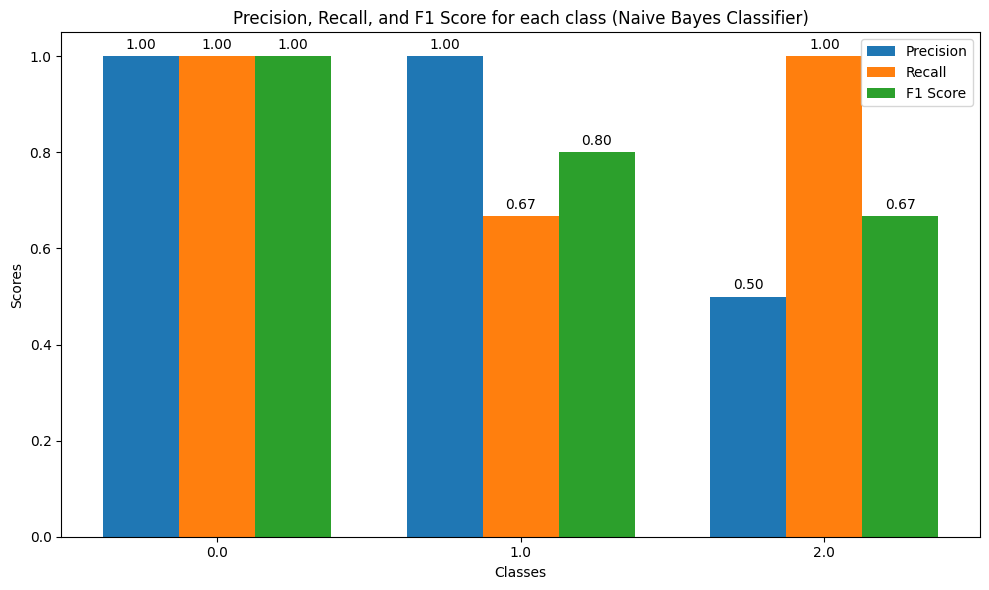

Confusion Matrix:
[[2. 0. 0.]
 [0. 2. 1.]
 [0. 0. 1.]]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.classification import NaiveBayes
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Naive Bayes Classifier (Multinomial model)
nb_classifier = NaiveBayes(featuresCol="features", labelCol="SalePrice_class_index", modelType="multinomial")
nb_model = nb_classifier.fit(train_data)
nb_predictions = nb_model.transform(test_data)

# Evaluate accuracy using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="SalePrice_class_index", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy}")

# Select necessary columns for evaluation: prediction and actual label (SalePrice_class_index)
predictions_and_labels = nb_predictions.select("prediction", "SalePrice_class_index").rdd

# Create an instance of MulticlassMetrics
metrics = MulticlassMetrics(predictions_and_labels)

# Precision, Recall, F1-Score for each class
labels = predictions_and_labels.map(lambda x: x[1]).distinct().collect()

precision_values = []
recall_values = []
f1_values = []

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)

    # Manually calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1_score)

# Prepare data for the plot
labels = [str(label) for label in labels]  # Convert class labels to strings for plot

# Set up the figure and axes
x = np.arange(len(labels))  # Class labels positions
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each metric
rects1 = ax.bar(x - width, precision_values, width, label='Precision')
rects2 = ax.bar(x, recall_values, width, label='Recall')
rects3 = ax.bar(x + width, f1_values, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score for each class (Naive Bayes Classifier)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to each bar
add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

# Show the plot
plt.tight_layout()
plt.show()

# Confusion Matrix
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(confusion_matrix)


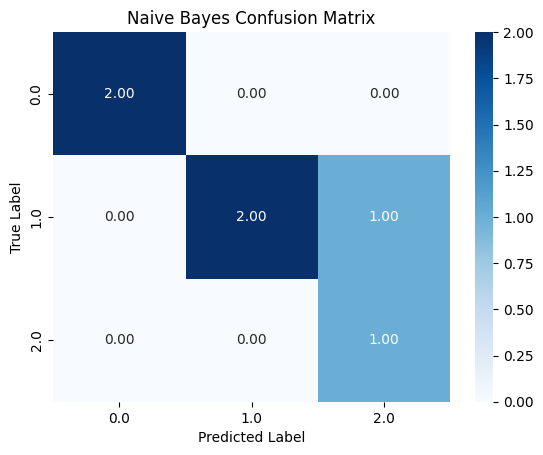

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Confusion Matrix
sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Random Forest Classifier
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="SalePrice_class_index", maxDepth=10, numTrees=100, maxBins=64)
rf_model = rf_classifier.fit(train_data)
rf_predictions = rf_model.transform(test_data)
# Accuracy Evaluation using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="SalePrice_class_index", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")
# Select only the necessary columns: prediction and the actual label (SalePrice_class_index)
predictions_and_labels = rf_predictions.select("prediction", "SalePrice_class_index").rdd
# Create an instance of MulticlassMetrics
metrics = MulticlassMetrics(predictions_and_labels)
# Precision, Recall, F1-Score for each class
labels = predictions_and_labels.map(lambda x: x[1]).distinct().collect()
for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1_score = metrics.fMeasure(label)

    print(f"Class {label}: Precision = {precision}, Recall = {recall}, F1 Score = {f1_score}")

# Overall Accuracy
accuracy = metrics.accuracy
print(f"Overall Accuracy: {accuracy}")

# Confusion Matrix
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(confusion_matrix)


24/12/20 15:48:37 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 64 to 20 (= number of training instances)


Random Forest Accuracy: 0.8333333333333334


/Volumes/Brady/UK/UEL/IS/env/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Class 0.0: Precision = 1.0, Recall = 1.0, F1 Score = 1.0
Class 1.0: Precision = 1.0, Recall = 0.6666666666666666, F1 Score = 0.8
Class 2.0: Precision = 0.5, Recall = 1.0, F1 Score = 0.6666666666666666
Overall Accuracy: 0.8333333333333334
Confusion Matrix:
[[2. 0. 0.]
 [0. 2. 1.]
 [0. 0. 1.]]


24/12/20 17:21:47 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 64 to 20 (= number of training instances)


Random Forest Accuracy: 0.8333333333333334


/Volumes/Brady/UK/UEL/IS/env/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


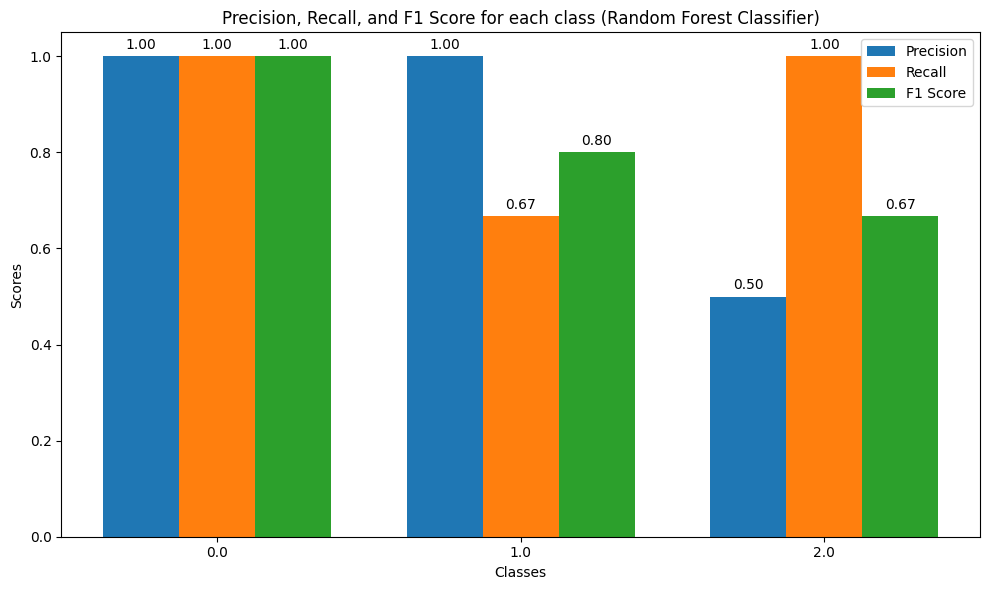

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Random Forest Classifier
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="SalePrice_class_index", maxDepth=10, numTrees=100, maxBins=64)
rf_model = rf_classifier.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Accuracy Evaluation using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="SalePrice_class_index", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

# Select only the necessary columns: prediction and the actual label (SalePrice_class_index)
predictions_and_labels = rf_predictions.select("prediction", "SalePrice_class_index").rdd

# Create an instance of MulticlassMetrics
metrics = MulticlassMetrics(predictions_and_labels)

# Precision, Recall, F1-Score for each class
labels = predictions_and_labels.map(lambda x: x[1]).distinct().collect()

precision_values = []
recall_values = []
f1_values = []

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)

    # Manually calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1_score)

# Prepare data for the plot
labels = [str(label) for label in labels]  # Class labels

# Set up the figure and axes
x = np.arange(len(labels))  # The class labels
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each metric
rects1 = ax.bar(x - width, precision_values, width, label='Precision')
rects2 = ax.bar(x, recall_values, width, label='Recall')
rects3 = ax.bar(x + width, f1_values, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score for each class (Random Forest Classifier)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to each bar
add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

# Show the plot
plt.tight_layout()
plt.show()


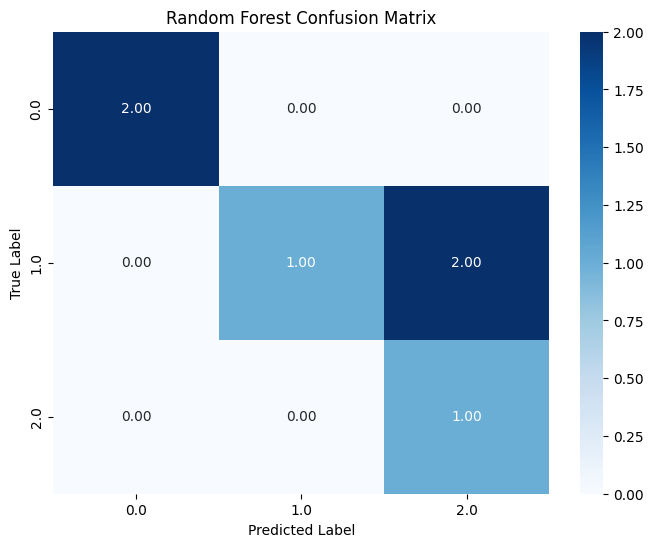

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming confusion_matrix is already computed for the Random Forest Classifier
# Convert the confusion matrix to a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
# Naive Bayes Tuning
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Define NaiveBayes Classifier
nb_classifier = NaiveBayes(featuresCol="features", labelCol="SalePrice_class_index", modelType="multinomial")

# Create a parameter grid for tuning
paramGrid = (ParamGridBuilder()
             .addGrid(nb_classifier.smoothing, [0.5, 1.0, 1.5])  # Test different smoothing values
             .addGrid(nb_classifier.modelType, ["multinomial"])  # Test different model types
             .build())

# Use CrossValidator for model selection
evaluator = MulticlassClassificationEvaluator(labelCol="SalePrice_class_index", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(estimator=nb_classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # 3-fold cross-validation

# Initialize a list to store the accuracies and parameters
accuracies = []

# Train model with cross-validation
cv_model = crossval.fit(train_data)

# Make predictions on test data
nb_predictions = cv_model.transform(test_data)

# Evaluate the best model
nb_accuracy = evaluator.evaluate(nb_predictions)
accuracies.append(("Best Naive Bayes Model Accuracy", nb_accuracy))

# Retrieve the best model's parameters
best_model = cv_model.bestModel
best_params = {
    "Smoothing": best_model._java_obj.getSmoothing(),
    "Model Type": best_model._java_obj.getModelType()
}

# Print the accuracy and best parameters for Naive Bayes
print(f"Tuned Naive Bayes Accuracy: {nb_accuracy}")
print("Best Model Parameters:", best_params)

# Print all the accuracies and parameters tested during cross-validation
print("\nAll accuracies and parameters tested:")
for acc in accuracies:
    print(f"{acc[0]}: {acc[1]}")

# Optionally, print the best model parameters for Naive Bayes
print(f"\nBest Parameters:\n - Smoothing: {best_params['Smoothing']}\n - Model Type: {best_params['Model Type']}")


24/12/20 07:22:27 WARN CacheManager: Asked to cache already cached data.
24/12/20 07:22:27 WARN CacheManager: Asked to cache already cached data.


Tuned Naive Bayes Accuracy: 0.8333333333333334
Best Model Parameters: {'Smoothing': 0.5, 'Model Type': 'multinomial'}

All accuracies and parameters tested:
Best Naive Bayes Model Accuracy: 0.8333333333333334

Best Parameters:
 - Smoothing: 0.5
 - Model Type: multinomial


In [ ]:
from pyspark.ml.classification import RandomForestClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Base classifier (e.g., Random Forest)
base_rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="SalePrice_class_index")

# One-vs-Rest classifier using RandomForestClassifier as the base
ovr_classifier = OneVsRest(classifier=base_rf_classifier, labelCol="SalePrice_class_index")

# Train the model
ovr_model = ovr_classifier.fit(train_data)

# Predict on the test set
ovr_predictions = ovr_model.transform(test_data)

# Evaluate the model's accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="SalePrice_class_index", predictionCol="prediction", metricName="accuracy")
ovr_accuracy = evaluator.evaluate(ovr_predictions)


print(f"One-vs-Rest Random Forest Accuracy: {ovr_accuracy}")


24/12/20 09:48:42 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
24/12/20 09:48:42 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
24/12/20 09:48:42 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)


One-vs-Rest Random Forest Accuracy: 0.6666666666666666


In [ ]:
from pyspark.ml.classification import RandomForestClassifier, OneVsRest
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Base classifier (RandomForest)
base_rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="SalePrice_class_index")
# One-vs-Rest classifier using RandomForestClassifier as the base
ovr_classifier = OneVsRest(classifier=base_rf_classifier, labelCol="SalePrice_class_index")
# Train the model
ovr_model = ovr_classifier.fit(train_data)
# Predict on the test set
ovr_predictions = ovr_model.transform(test_data)
# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="SalePrice_class_index", predictionCol="prediction", metricName="accuracy")
ovr_accuracy = evaluator.evaluate(ovr_predictions)
print(f"One-vs-Rest Random Forest Accuracy: {ovr_accuracy}")
# Select prediction and actual label columns for evaluation
predictions_and_labels = ovr_predictions.select("prediction", "SalePrice_class_index").rdd
# Create an instance of MulticlassMetrics
metrics = MulticlassMetrics(predictions_and_labels)
# Precision, Recall, F1-Score for each class
labels = predictions_and_labels.map(lambda x: x[1]).distinct().collect()
for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1_score = metrics.fMeasure(label)
    print(f"Class {label}: Precision = {precision}, Recall = {recall}, F1 Score = {f1_score}")
# Overall Accuracy
accuracy = metrics.accuracy
print(f"Overall Accuracy: {accuracy}")

# Confusion Matrix
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(confusion_matrix)


24/12/20 15:49:58 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
24/12/20 15:49:59 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
24/12/20 15:49:59 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)


One-vs-Rest Random Forest Accuracy: 0.6666666666666666


Class 0.0: Precision = 1.0, Recall = 1.0, F1 Score = 1.0
Class 1.0: Precision = 1.0, Recall = 0.3333333333333333, F1 Score = 0.5
Class 2.0: Precision = 0.3333333333333333, Recall = 1.0, F1 Score = 0.5
Overall Accuracy: 0.6666666666666666
Confusion Matrix:
[[2. 0. 0.]
 [0. 1. 2.]
 [0. 0. 1.]]


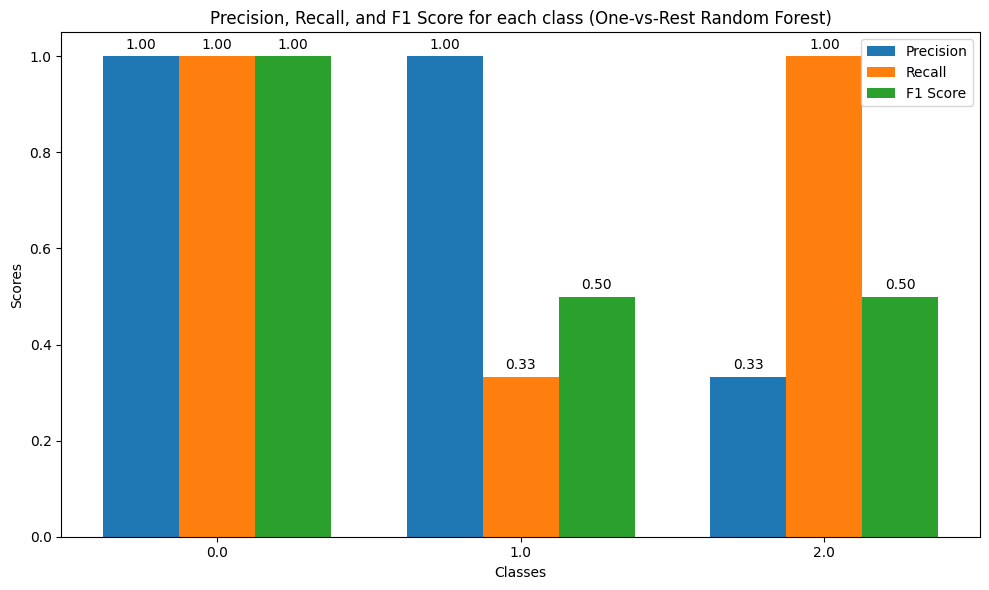

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Get precision and recall values for each class
labels = predictions_and_labels.map(lambda x: x[1]).distinct().collect()

precision_values = []
recall_values = []
f1_values = []

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)

    # Manually calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1_score)

# Prepare data for the plot
labels = [str(label) for label in labels]  # Class labels

# Set up the figure and axes
x = np.arange(len(labels))  # The class labels
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each metric
rects1 = ax.bar(x - width, precision_values, width, label='Precision')
rects2 = ax.bar(x, recall_values, width, label='Recall')
rects3 = ax.bar(x + width, f1_values, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score for each class (One-vs-Rest Random Forest)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to each bar
add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

# Show the plot
plt.tight_layout()
plt.show()


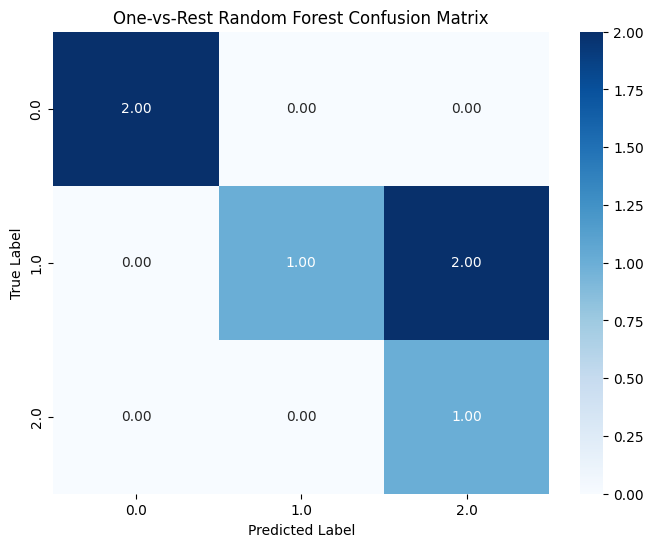

In [ ]:
# Assuming confusion_matrix is already computed for the One-vs-Rest Random Forest Classifier
# Convert the confusion matrix to a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("One-vs-Rest Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
from pyspark.ml.classification import LogisticRegression

# Logistic Regression with regularization (L2)
lr_classifier = LogisticRegression(featuresCol="features", labelCol="SalePrice_class_index", maxIter=10, regParam=0.1)
lr_model = lr_classifier.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Evaluate Logistic Regression
lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")


Logistic Regression Accuracy: 0.5596649198612039


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics

# Logistic Regression with regularization (L2)
lr_classifier = LogisticRegression(featuresCol="features", labelCol="SalePrice_class_index", maxIter=10, regParam=0.1)
lr_model = lr_classifier.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Select only the necessary columns: prediction and the actual label (SalePrice_class_index)
# kmeans_predictions = kmeans_predictions.withColumn("prediction", col("prediction").cast("double"))
predictions_and_labels = lr_predictions.select("prediction", "SalePrice_class_index").rdd

# Create an instance of MulticlassMetrics
metrics = MulticlassMetrics(predictions_and_labels)

# Precision, Recall, F1-Score for each class
labels = predictions_and_labels.map(lambda x: x[1]).distinct().collect()

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1_score = metrics.fMeasure(label)

    print(f"Class {label}: Precision = {precision}, Recall = {recall}, F1 Score = {f1_score}")

# Overall Accuracy
accuracy = metrics.accuracy
print(f"Overall Accuracy: {accuracy}")

# Confusion Matrix
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(confusion_matrix)


Class 0.0: Precision = 0.6666666666666666, Recall = 1.0, F1 Score = 0.8
Class 1.0: Precision = 1.0, Recall = 1.0, F1 Score = 1.0
Class 2.0: Precision = 0.0, Recall = 0.0, F1 Score = 0.0
Overall Accuracy: 0.8333333333333334
Confusion Matrix:
[[2. 0. 0.]
 [0. 3. 0.]
 [1. 0. 0.]]
